# Finding Cosmological parameters from Observational Data
## Habiba Hazem ElQwaisney

In [62]:
pip install corner

In [49]:
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams

rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20

In [50]:
pip install emcee


     ---------------------------------------- 0.0/46.2 kB ? eta -:--:--
     ----------------------------------- ---- 41.0/46.2 kB 1.9 MB/s eta 0:00:01
     -------------------------------------- 46.2/46.2 kB 580.3 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


# Hubble Function

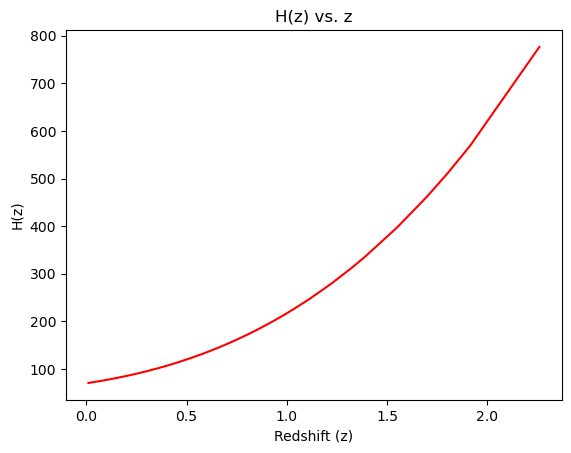

In [40]:
import numpy as np
import scipy.integrate as spi
from scipy.integrate import quad
import matplotlib.pyplot as plt
import math as m

# Constants
c = 299792.458  # speed of light in km/s
H_0 = 70  # Hubble Constant in km/s.Mpc
omega_m = 0.3
omega_k = 0
omega_d = 1 - omega_m

# Load observational data
data = np.loadtxt("mu-obs.dat", unpack=True)
z, mu, sigma = data

def H(z):
    return H_0 * (omega_m * (1 + z) ** 3 + omega_k * (1 + z) ** 2 + omega_d)

plt.plot(z, H(z),color= 'red')
plt.xlabel('Redshift (z)')
plt.ylabel('H(z)')
plt.title("H(z) vs. z")
plt.show()


## Distasnce Modulus

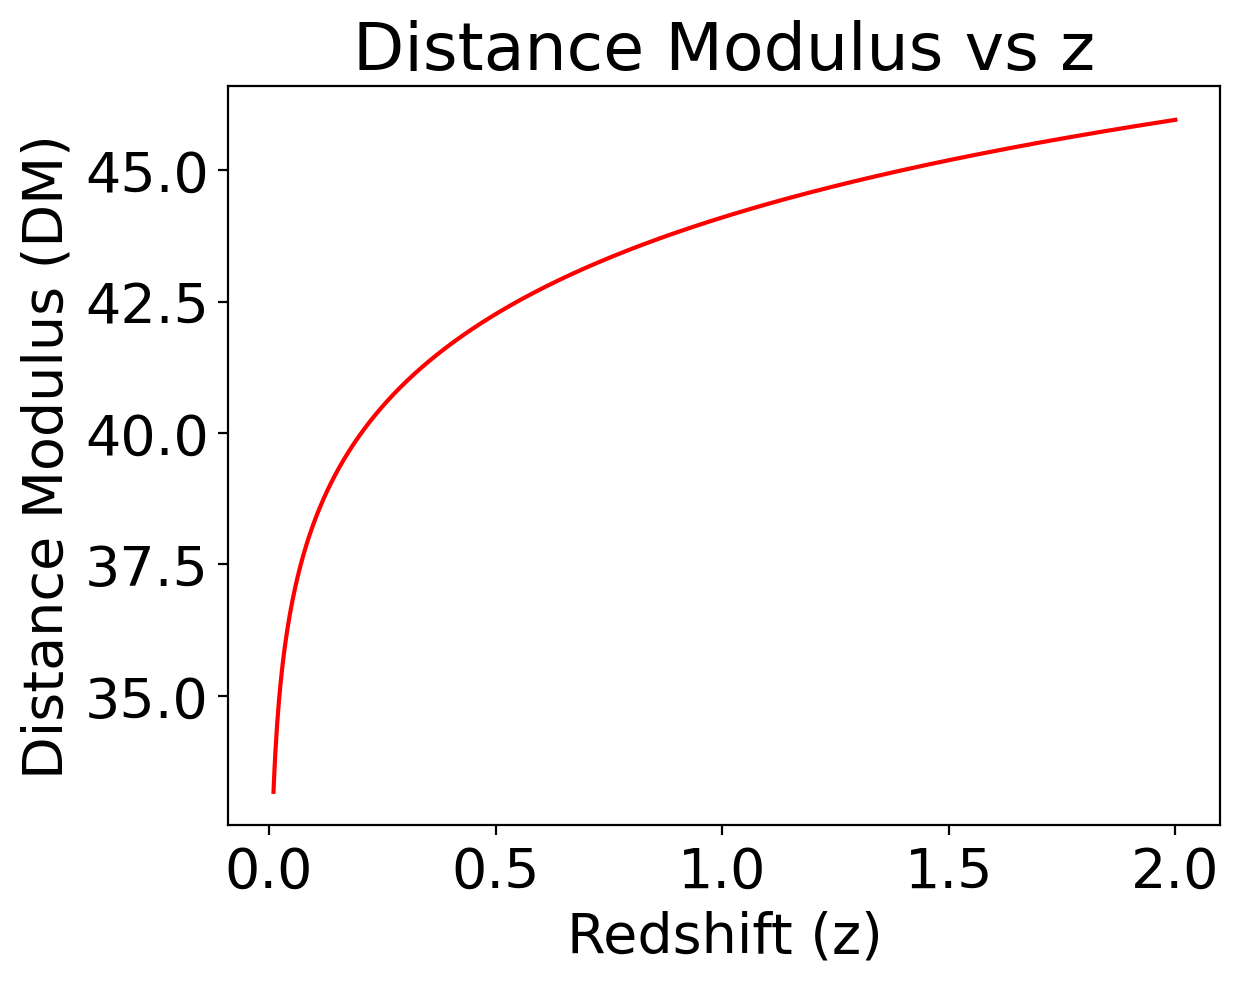

In [81]:
def D_M(z, H, omega):
    integrand = lambda x: (c / H) * (1 / (m.sqrt(omega * (1 + x) ** 3 + 1 - omega)))
    D_M = [(5 * np.log10((1 + n) * quad(integrand, 0, n)[0])) + 25 for n in z]
    return D_M
plt.plot(z, D_M(z, H_0, omega_m), color='red')
plt.title("Distance Modulus vs z")
plt.xlabel('Redshift (z)')
plt.ylabel('Distance Modulus (DM)')
plt.show()

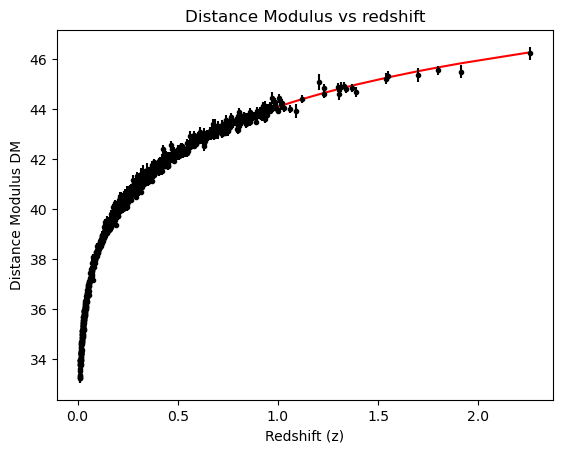

In [39]:
plt.plot(z, D_M(z, H_0, omega_m), color='red')
plt.errorbar(z, mu, yerr=sigma, fmt = ".k", capsize = 0)
plt.title("Distance Modulus vs redshift")
plt.xlabel('Redshift (z)')
plt.ylabel('Distance Modulus DM')
plt.show()

## Likelyhood Estimation


In [57]:
def log_likelihood(theta, x, y, yerr):
    omega, H = theta
    model = D_M(x, H, omega)
    sigma2 = yerr**2
    return (-0.5 * np.sum((y - model) ** 2 / sigma2))


def log_prior(theta):
    omega, H  = theta
    if 50.0 < H < 100.0 and 0.0 < omega < 1.0:
        return 0.0
    return -np.inf


def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

import emcee
from tqdm import tqdm

pos = np.array([omega_m, H_0]) + 1e-4 * np.random.randn(30, 2)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(z, mu, sigma)
)
sampler.run_mcmc(pos, 10000, progress=True);

100%|██████████| 10000/10000 [7:33:57<00:00,  2.72s/it]      


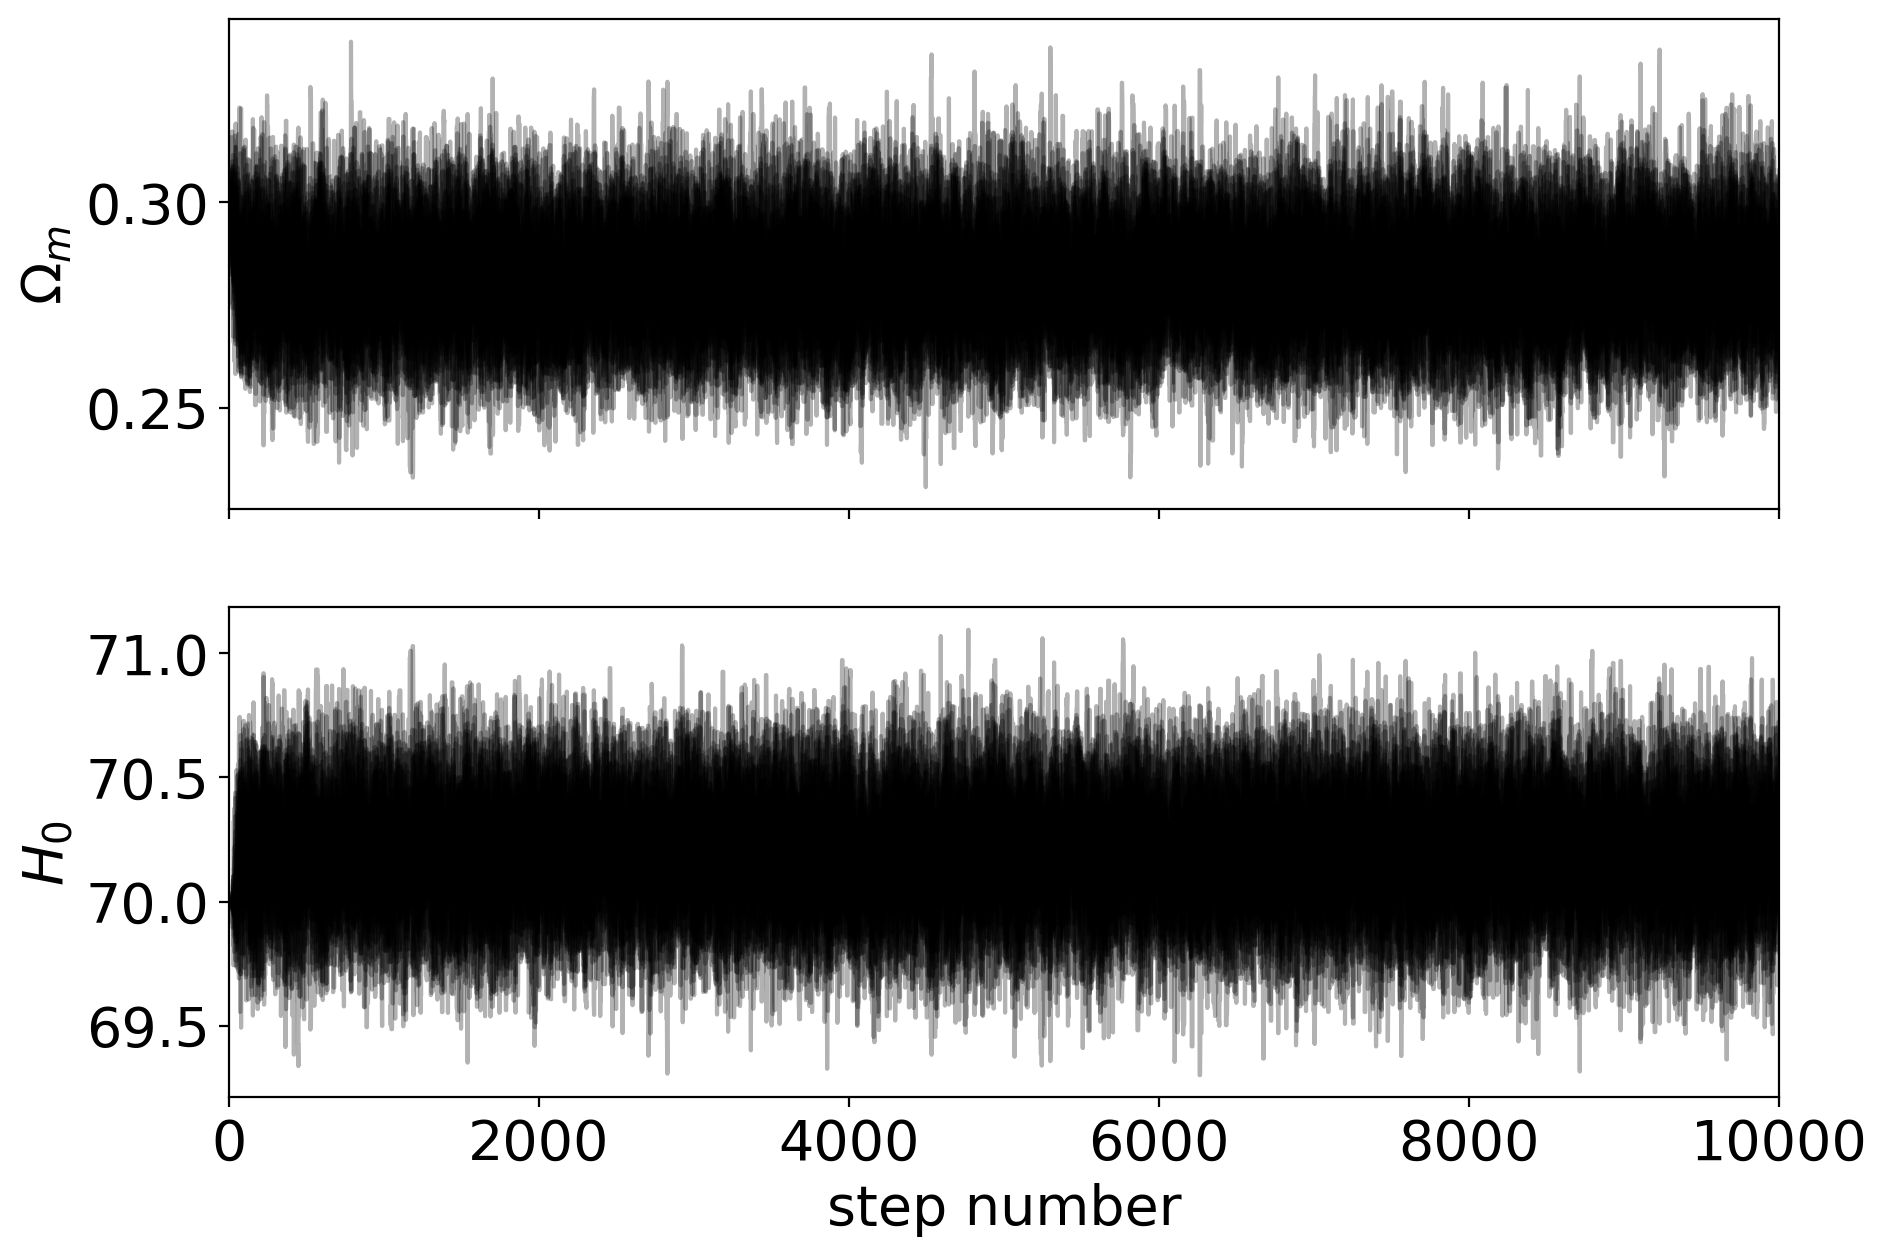

In [75]:
from IPython.display import display, Math
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = [r"$\Omega_m$", r"$H_0$"] 
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

plt.show()


In [59]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(19800, 2)


## RESULTS

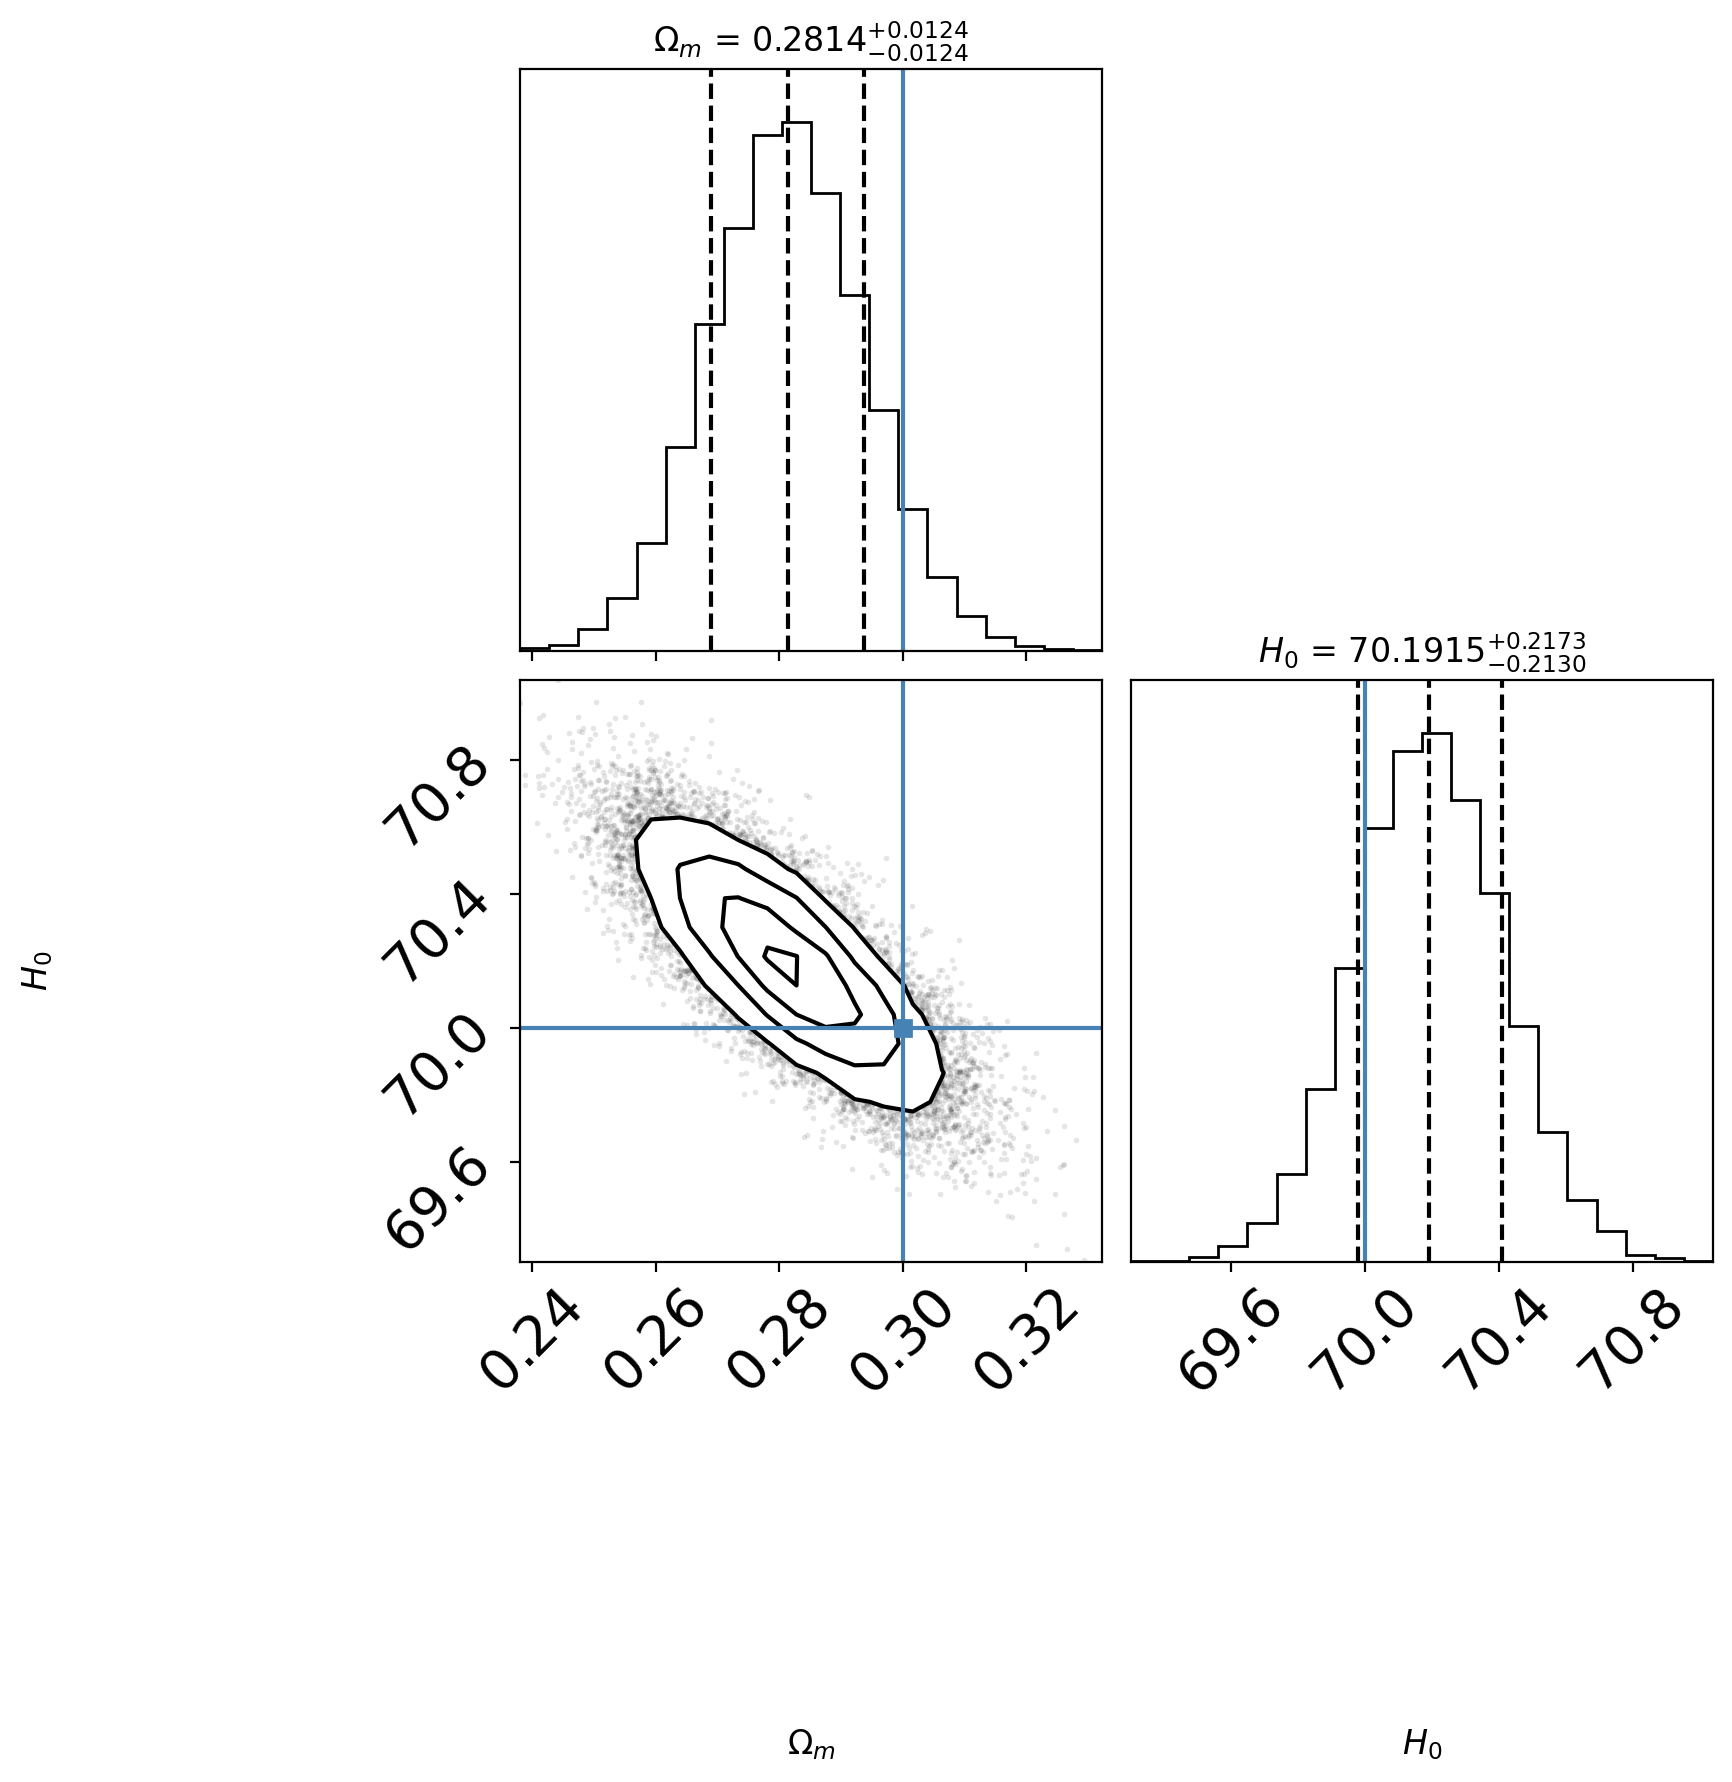

In [83]:
import corner
import matplotlib.pyplot as plt

H_H = 70

fig = corner.corner(
    flat_samples,
    labels=labels,
    truths=[omega_m, H_0],
    quantiles=[0.16, 0.5, 0.84],  
    show_titles=True, 
    title_fmt=".4f",  
    title_kwargs={"fontsize": 12},  
    label_kwargs={"fontsize": 12}, 
    labelpad=0.5,  
    truths_kwargs={"color": "blue", "linestyle": "--"},  
    fig=plt.gcf(),  
    plot_contours=True,  
    use_math_text=True, 
    hist_kwargs={"density": True},  
    max_n_ticks=5, 
    no_fill_contours=False, 
    plot_density=False,
    verbose=False
)

fig.set_size_inches(8, 8)

In [65]:
labels=["\Omega_m", "H_0"]
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>